![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import re

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [9]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [10]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [11]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [ ]:
df_train.head(5)

In [ ]:
df_test.info()

In [ ]:
df_test.head(5)

In [ ]:
sample_submission.head(5)

In [ ]:
sample_submission.info()

In [ ]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [ ]:
data.columns

In [ ]:
#Приводим имена столбцов к удобному формату
#Проверил работу конструкции
for col in data.columns :
    print('_'.join(col.split()).lower()) 

In [ ]:
#Переименовал    
data.columns = ['_'.join(col.split()).lower() for col in data.columns]

In [ ]:
data.info()

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [ ]:
data.sample(5)

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

# number_of_reviews

In [ ]:
# Для примера я возьму столбец Number of Reviews
data['number_of_reviews_isNAN'] = pd.isna(data['number_of_reviews']).astype('uint8')

In [ ]:
# Заполняем средним значением по городу. Получим его
mean_revs = data.groupby('city')['number_of_reviews'].mean()
mean_revs

In [ ]:
data['number_of_reviews'] = data.apply(lambda x: mean_revs[x['city']] if pd.isnull(x['number_of_reviews']) else x['number_of_reviews'], axis=1)

# cuisine_style

In [ ]:
# Как всегда, чтоьы понимать пришло ли значение признака из датасета или сгенерировано нами
data['cuisine_style_isNAN'] = pd.isna(data['cuisine_style']).astype('uint8')
#Заменяем пустые значения в cuisine_style на местную кухню
data.cuisine_style = data.cuisine_style.fillna(value='regional')

# price_range

In [ ]:
data['price_range'].value_counts()

In [ ]:
data['price_range_isNAN'] = pd.isna(data['price_range']).astype('uint8')
#Заполняем пропуски самым распространенным значением
data['price_range'] = data['price_range'].fillna(value='$$ - $$$')

# reviews

In [ ]:
pd.DataFrame(data.reviews.value_counts())

In [ ]:
#Заменим 8112 пустых отзывов на np.nan
data.reviews = data.reviews.apply(lambda string: np.nan if string == '[[], []]' else string)

In [ ]:
pd.DataFrame(data.reviews.value_counts())

In [ ]:
data.info()

### 2. Обработка признаков


In [ ]:
def get_first_date_rev(d):
#Получаем дату первого отзыва на сайте    
    if str(d) == 'nan':
        return 0
    dd=d.replace('[[','[')
    dd=dd.replace(']]',']')
    dd=dd.replace('"',"'")
    lst=re.findall(r"\[(.*?)\]",dd)
    if len(lst[1]) == 0:
        return None
    dls=lst[1].replace("'",'').split(',')
    dts=list(map(lambda x : x.strip(),dls))
    if len(dts) == 1:
        return dts[0]
    return dts[1]

gfd=get_first_date_rev

def get_last_date_rev(d):
#Получаем дату последнего отзыва на сайте
    if str(d) == 'nan':
        return 0
    dd=d.replace('[[','[')
    dd=dd.replace(']]',']')
    dd=dd.replace('"',"'")
    lst=re.findall(r"\[(.*?)\]",dd)
    if len(lst[1]) == 0:
        return None
    dls=lst[1].replace("'",'').split(',')
    dts=list(map(lambda x : x.strip(),dls))
    return dts[0]

gld=get_last_date_rev

def look_at_cuisen(df):
#Исследуем признак  'Cuisine Style'. Функцис вернет список кухонь, которые встречаются в датасете 
#Переменная dict использовалась для подсчета частоты встречаемости кухонь.
    kit=set()
    kit_dict={}
    for k in df['cuisine_style']:
        if str(k) != 'nan':
            #k=k[1,-1]
            k=k.replace("'",'')
            lst=k[1:-1].split(',')
            #print(len(lst))
            for j in lst:
                kit.add(j.strip())
                if kit_dict.get(j) == None:
                    kit_dict.setdefault(j,1)
                else:
                    kit_dict[j]=kit_dict[j]+1
    s_kit=sorted(kit)                
    #print(s_kit)
    return s_kit   


def add_cuis(lst,df):
    for i in lst:
        cu_name='сuisine_'+i
        df[cu_name]=0
        
        
def cuis_dumm(x):
    
    if str(x['cuisine_style']) == 'nan':
        return x
    for i in cuis_list:
        if i in x['cuisine_style']:
            cu_name='сuisine_'+i
            #print(cu_name,'=1')
            x.loc[cu_name]=1
    return x    



def get_cuisines(k):
    if str(k) != 'regional':
        k=k.replace("'",'')
        lst=k[1:-1].split(',')
        return len(lst)
    else:
        return 1
    
    
def get_price_type(x):
    if x=='$':
        #print(1)
        return 1
    if x=='$$ - $$$':
        #print(2)
        return 2
    if x=='$$$$':
        #print(3)
        return 3
    


In [ ]:
#Создадим признак - количество кухонь, представленных в данном ресторане
data['cuisines_col']=data['cuisine_style'].apply(get_cuisines)

In [ ]:
data['cuisines_col'].max()

In [ ]:
#Из признака reviews получили следующие:
#1. Дата первого отзыва, размещенного на сайте 
#2. Дата последнего отзыва, размещенного на сайте ресторана
#3. Получили разницу во времени между первым и последним отзывом
data['first_rev_date']=pd.to_datetime(data['reviews'].apply(gfd))
data['last_rev_date']=pd.to_datetime(data['reviews'].apply(gld))
#data['first_rev_date']=pd.to_datetime(data['first_rev_date'])
#data['last_rev_date']=pd.to_datetime(data['last_rev_date'])
data['days_passed']=(data['last_rev_date']-data['first_rev_date']).dt.days

In [ ]:
data.query('days_passed < 0')[['first_rev_date','last_rev_date','days_passed']]

In [ ]:
#Есть отрицательные значения разницы. Возможно перепутаны даты первого и последнего отзыва. Исправим.
data['days_passed']=data['days_passed'].apply(lambda x : abs(x)) 

# А может это и не надо исправлять. 


In [ ]:
data.head(5)

In [ ]:
data.sample(5)

In [ ]:

data['price_range']=data['price_range'].apply(get_price_type)

In [ ]:
# Рейтинги столичных ресторанов, как правило, в среднем повыше. Добавим признак "столичности" расторана
capitals ={
 'Amsterdam' : 1,
 'Athens' : 1,
 'Barcelona' : 0,
 'Berlin' : 1,
 'Bratislava' : 1,
 'Brussels' : 1,
 'Budapest' : 1,
 'Copenhagen' : 1,
 'Dublin' : 1,
 'Edinburgh' : 0,
 'Geneva' : 0,
 'Hamburg' : 0,
 'Helsinki' : 1,
 'Krakow' : 0,
 'Lisbon' : 1,
 'Ljubljana' : 1,
 'London' : 1,
 'Luxembourg' : 1,
 'Lyon' : 1,
 'Madrid' : 1,
 'Milan' : 0,
 'Munich' : 0,
 'Oporto' : 0,
 'Oslo' : 1,
 'Paris' : 1,
 'Prague' : 1,
 'Rome' : 1,
 'Stockholm' : 1,
 'Vienna' : 1,
 'Warsaw' : 1,
 'Zurich' : 0
}
data['capital'] = data['city'].map(capitals)

In [ ]:
# Добавим признак - отношение рейтинга ресторана к общему количеству ресторанов в городе (данные взяты с сайта https://www.tripadvisor.ru/)
rest_count={
 'Amsterdam' : 3988,
 'Athens' : 2538,
 'Barcelona' : 9517,
 'Berlin' : 6300,
 'Bratislava' : 1264,
 'Brussels' : 3626,
 'Budapest' : 3058,
 'Copenhagen' : 2344,
 'Dublin' : 2346,
 'Edinburgh' : 1899,
 'Geneva' : 1600,
 'Hamburg' : 3260,
 'Helsinki' : 1504 ,
 'Krakow' : 1758,
 'Lisbon' : 4906,
 'Ljubljana' : 600,
 'London' : 19945,
 'Luxembourg' : 739,
 'Lyon' : 2790,
 'Madrid' : 11382,
 'Milan' : 7434,
 'Munich' : 3150,
 'Oporto' : 1988,
 'Oslo' : 1275,
 'Paris' : 17146,
 'Prague' : 5394,
 'Rome' : 10959,
 'Stockholm' : 3008,
 'Vienna' : 4117,
 'Warsaw' : 3246,
 'Zurich' : 1851
}

data['rests'] = data.city.map(rest_count)
#Создадим признак
data['rank_ratio'] = data.ranking / data.rests

In [ ]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data,columns=['city'],dummy_na=True)

In [ ]:
data

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

In [ ]:
data['cuisines_col']

In [ ]:
# Снова One-Hot Encoding. В кустарном исполнении. Разворачивам в dummy кухни
cuis_list=look_at_cuisen(data)
add_cuis(cuis_list,data)
data=data.apply(cuis_dumm,axis=1)

In [ ]:
data

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

In [ ]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

In [ ]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

In [ ]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

In [ ]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

In [ ]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

In [ ]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

In [ ]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [ ]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [35]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
#Переименовал колонки для более комфортной работы
data.columns = ['_'.join(col.split()).lower() for col in data.columns]
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
restaurant_id        50000 non-null object
city                 50000 non-null object
cuisine_style        38410 non-null object
ranking              50000 non-null float64
price_range          32639 non-null object
number_of_reviews    46800 non-null float64
reviews              49998 non-null object
url_ta               50000 non-null object
id_ta                50000 non-null object
sample               50000 non-null int64
rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [36]:


def get_first_date_rev(d):
#Получаем дату первого отзыва на сайте    
    if str(d) == 'nan':
        return 0
    dd=d.replace('[[','[')
    dd=dd.replace(']]',']')
    dd=dd.replace('"',"'")
    lst=re.findall(r"\[(.*?)\]",dd)
    if len(lst[1]) == 0:
        return None
    dls=lst[1].replace("'",'').split(',')
    dts=list(map(lambda x : x.strip(),dls))
    if len(dts) == 1:
        return dts[0]
    return dts[1]

gfd=get_first_date_rev

def get_last_date_rev(d):
#Получаем дату последнего отзыва на сайте
    if str(d) == 'nan':
        return 0
    dd=d.replace('[[','[')
    dd=dd.replace(']]',']')
    dd=dd.replace('"',"'")
    lst=re.findall(r"\[(.*?)\]",dd)
    if len(lst[1]) == 0:
        return None
    dls=lst[1].replace("'",'').split(',')
    dts=list(map(lambda x : x.strip(),dls))
    return dts[0]

gld=get_last_date_rev

def look_at_cuisen(df):
#Исследуем признак  'Cuisine Style'. Функцис вернет список кухонь, которые встречаются в датасете 
#Переменная dict использовалась для подсчета частоты встречаемости кухонь.
    kit=set()
    kit_dict={}
    for k in df['cuisine_style']:
        if str(k) != 'nan':
            #k=k[1,-1]
            k=k.replace("'",'')
            lst=k[1:-1].split(',')
            #print(len(lst))
            for j in lst:
                kit.add(j.strip())
                if kit_dict.get(j) == None:
                    kit_dict.setdefault(j,1)
                else:
                    kit_dict[j]=kit_dict[j]+1
    s_kit=sorted(kit)                
    #print(s_kit)
    return s_kit   



def add_cuis(lst,df):
    for i in lst:
        cu_name='сuisine_'+i
        df[cu_name]=0
        

        
def cuis_dumm(x,cuis_list):
    
    if str(x['cuisine_style']) == 'nan':
        return x
    for i in cuis_list:
        if i in x['cuisine_style']:
            cu_name='сuisine_'+i
            #print(cu_name,'=1')
            x.loc[cu_name]=1
    return x    



def get_cuisines(k):
    if str(k) != 'regional':
        k=k.replace("'",'')
        lst=k[1:-1].split(',')
        return len(lst)
    else:
        return 1
    
    
def get_price_type(x):
    if x=='$':
        #print(1)
        return 1
    if x=='$$ - $$$':
        #print(2)
        return 2
    if x=='$$$$':
        #print(3)
        return 3
    


    
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['restaurant_id','id_ta',], axis = 1, inplace=True)
    
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    #df_output['number_of_reviews_isNAN'] = pd.isna(data['number_of_reviews']).astype('uint8')
    
    #df_output['Number of Reviews'].fillna(0, inplace=True)
    
    # Заполняем пропуски в number_of_reviews средним значением по городу. Получим его
    
    mean_revs = df_output.groupby('city')['number_of_reviews'].mean()
    df_output['number_of_reviews'] = df_output.apply(lambda x: mean_revs[x['city']] if pd.isnull(x['number_of_reviews']) else x['number_of_reviews'], axis=1)
    
    #Заменяем пустые значения в cuisine_style на местную кухню
    df_output.cuisine_style = df_output.cuisine_style.fillna(value='regional')

    #Заполняем пропуски price_range самым распространенным значением
    df_output['price_range'] = df_output['price_range'].fillna(value='$$ - $$$')
    
    #Заменим 8112 пустых отзывов на np.nan для простоты обработки в дальнейшем
    df_output.reviews = df_output.reviews.apply(lambda string: np.nan if string == '[[], []]' else string)
    
    
    
    # ################### 3. Поработаем с признаками ############################################################## 
    
    #Создадим признак - количество кухонь, представленных в данном ресторане
    df_output
    cuis_list=look_at_cuisen(df_output)
    add_cuis(cuis_list,df_output)
    df_output['cuisines_col']=df_output['cuisine_style'].apply(get_cuisines)
    
    #Из признака reviews получили следующие:
    #1. Дата первого отзыва, размещенного на сайте 
    #2. Дата последнего отзыва, размещенного на сайте ресторана
    #3. Получили разницу во времени между первым и последним отзывом
    df_output['first_rev_date']=pd.to_datetime(df_output['reviews'].apply(gfd))
    df_output['last_rev_date']=pd.to_datetime(df_output['reviews'].apply(gld))
    df_output['days_passed']=(df_output['last_rev_date']-df_output['first_rev_date']).dt.days
    df_output['days_passed']=df_output['days_passed'].apply(lambda x : float(x)) 
    
    #Есть отрицательные значения разницы. Возможно перепутаны даты первого и последнего отзыва. Исправим.
        #df_output['days_passed']=df_output['days_passed'].apply(lambda x : abs(x)) 
    
    
    # Рейтинги столичных ресторанов, как правило, в среднем повыше. Добавим признак "столичности" расторана
    capitals ={
     'Amsterdam' : 1,
     'Athens' : 1,
     'Barcelona' : 0,
     'Berlin' : 1,
     'Bratislava' : 1,
     'Brussels' : 1,
     'Budapest' : 1,
     'Copenhagen' : 1,
     'Dublin' : 1,
     'Edinburgh' : 0,
     'Geneva' : 0,
     'Hamburg' : 0,
     'Helsinki' : 1,
     'Krakow' : 0,
     'Lisbon' : 1,
     'Ljubljana' : 1,
     'London' : 1,
     'Luxembourg' : 1,
     'Lyon' : 1,
     'Madrid' : 1,
     'Milan' : 0,
     'Munich' : 0,
     'Oporto' : 0,
     'Oslo' : 1,
     'Paris' : 1,
     'Prague' : 1,
     'Rome' : 1,
     'Stockholm' : 1,
     'Vienna' : 1,
     'Warsaw' : 1,
     'Zurich' : 0
    }
    
    df_output['capital'] = df_output['city'].map(capitals)
    
    
    # Добавим признак - отношение рейтинга ресторана к общему количеству ресторанов в городе (данные 
    # о количестве ресторанов в городе взяты с сайта https://www.tripadvisor.ru/)
    rest_count={
     'Amsterdam' : 3988,
     'Athens' : 2538,
     'Barcelona' : 9517,
     'Berlin' : 6300,
     'Bratislava' : 1264,
     'Brussels' : 3626,
     'Budapest' : 3058,
     'Copenhagen' : 2344,
     'Dublin' : 2346,
     'Edinburgh' : 1899,
     'Geneva' : 1600,
     'Hamburg' : 3260,
     'Helsinki' : 1504 ,
     'Krakow' : 1758,
     'Lisbon' : 4906,
     'Ljubljana' : 600,
     'London' : 19945,
     'Luxembourg' : 739,
     'Lyon' : 2790,
     'Madrid' : 11382,
     'Milan' : 7434,
     'Munich' : 3150,
     'Oporto' : 1988,
     'Oslo' : 1275,
     'Paris' : 17146,
     'Prague' : 5394,
     'Rome' : 10959,
     'Stockholm' : 3008,
     'Vienna' : 4117,
     'Warsaw' : 3246,
     'Zurich' : 1851
}

    df_output['rests'] = df_output.city.map(rest_count)
    #Создадим признак
    df_output['rank_ratio'] = df_output.ranking / df_output.rests

    # Добавим признак - количество ресторанов на душу населения
    populate={
     'Amsterdam' : 872757,
     'Athens' : 655780,
     'Barcelona' : 1636762,
     'Berlin' : 3669491,
     'Bratislava' : 437725,
     'Brussels' : 1211035,
     'Budapest' : 1768073,
     'Copenhagen' : 615993,
     'Dublin' : 553165,
     'Edinburgh' : 482005,
     'Geneva' : 499480,
     'Hamburg' : 1899160,
     'Helsinki' : 655281 ,
     'Krakow' : 779115,
     'Lisbon' : 506654,
     'Ljubljana' : 281226,
     'London' : 9126366,
     'Luxembourg' : 626108,
     'Lyon' : 513275,
     'Madrid' : 3334730,
     'Milan' : 1404239,
     'Munich' : 1471508,
     'Oporto' : 214349,
     'Oslo' : 673469,
     'Paris' : 2148327,
     'Prague' : 1324277,
     'Rome' : 2790712,
     'Stockholm' : 961609,
     'Vienna' : 1921153,
     'Warsaw' : 1793579,
     'Zurich' : 402762
}
    
    
    
    df_output['populate'] = df_output.city.map(populate)
    #Создадим признак количество ресторанов на душу населения
    df_output['rests_per_pop'] = df_output.rests / df_output.populate   
    

    #Создадим признак количество отзывов на душу населения
    df_output['reviws_per_pop'] = df_output.number_of_reviews / df_output.populate   
    
 
    
    # ################### 4. Encoding ####################################################
    # One-hot encoding для признака City
    df_output = pd.get_dummies(df_output,columns=['city'],dummy_na=True)
    #Создадим ранговый признак price_range 
    df_output['price_range']=df_output['price_range'].apply(get_price_type)
    
    # Снова One-Hot Encoding. В кустарном исполнении. Разворачивам в dummy кухни
        
    #cuis_list=look_at_cuisen(df_output)
    add_cuis(cuis_list,df_output)
    df_output=df_output.apply(lambda x : cuis_dumm(x,cuis_list),axis=1)    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    object_columns.append('first_rev_date')
    object_columns.append('last_rev_date')
    df_output.drop(object_columns, axis = 1, inplace=True)
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [37]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,ranking,price_range,number_of_reviews,sample,rating,сuisine_Afghani,сuisine_African,сuisine_Albanian,сuisine_American,сuisine_Arabic,...,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,city_nan
41584,5544.0,2,4.0,1,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35056,9716.0,1,17.0,1,3.5,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
43970,3305.0,2,71.0,1,4.5,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
38514,5026.0,1,103.0,1,3.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2812,1101.0,2,28.0,0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23278,462.0,2,65.0,1,4.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
11866,11928.0,2,142.0,1,3.5,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
21593,13214.0,2,4.0,1,3.5,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2886,3313.0,2,31.0,0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6307,1474.0,1,43.0,0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
df_preproc.reviws_per_pop

0        0.000002
1        0.000148
2        0.000058
3        0.000022
4        0.000370
           ...   
49995    0.000056
49996    0.000252
49997    0.000004
49998    0.000039
49999    0.000185
Name: reviws_per_pop, Length: 50000, dtype: float64

In [39]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [28]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [29]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 169), (40000, 169), (40000, 168), (32000, 168), (8000, 168))

# Model 
Сам ML

In [30]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [31]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [32]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [33]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются 
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
#MAE: 0.20669187499999997

MAE: 0.205081875


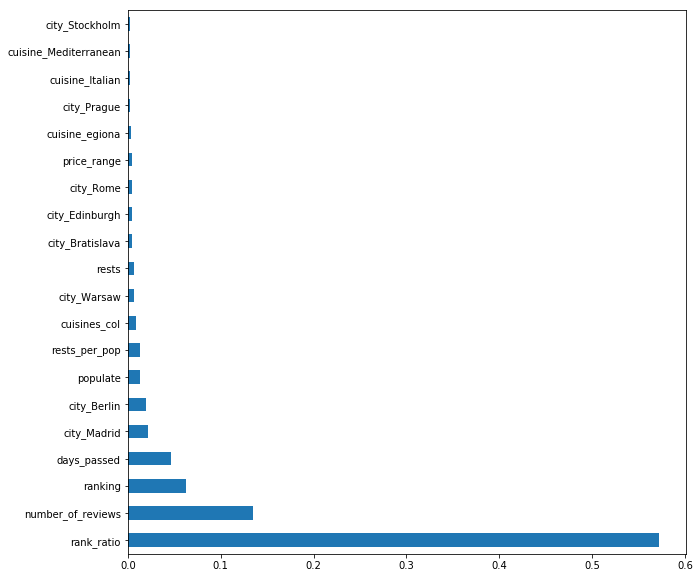

In [34]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['rating'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
